In [1]:
from __future__ import print_function

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard,ReduceLROnPlateau

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
# from tensorflow.keras.datasets import mnist, cifar10
import tensorflow_addons as tfa

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy.io import loadmat 
import mat73
from datetime import datetime
import ipynbname

print("Packages Loaded")

Packages Loaded


In [2]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="my-test-project", entity="ibksolar", name=ipynbname.name()+"Attention_first")
 


wandb: Currently logged in as: ibksolar (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [3]:
# base_path = '..\\..\\all_block_data\Dec_Train_block_len_21_011121_2331'
base_path = '../all_block_data/Old_data/Dec_Train_block_len_21_231121_1531'

# Confirm path is right...
print(f'{os.path.isdir(base_path)}')

True


In [6]:

raw_data1 = mat73.loadmat(base_path + '/echo_cnn_in_out_jstars.mat')
all_data = raw_data1['echo_cnn_input']
all_target = raw_data1['echo_cnn_target']
all_coords = raw_data1['coords']
echo_idx =raw_data1['orig_echo_idx']


# Set all nan in the data to zero
nan_idx = np.isnan(all_data).any(axis =-1)
all_target[nan_idx] = 0
all_data[ np.isnan(all_data) ]= 0

print(f'Sum of NaNs in data is {np.sum(np.any(np.isnan(all_data)))}; in target is {np.sum(np.any(np.isnan(all_target)))} ')

Sum of NaNs in data is 0; in target is 0 


In [5]:
# # Load data
# # raw_data1 = loadmat('new_echo_cnn_in_out_jstarrs2021_first_try/echo_cnn_in_out_jstars1.mat')
# # raw_data1 = loadmat('echo_cnn_in_out_GOOD_layers/new_echo_cnn_in_out_jstars1.mat') 'findpeaks_layers/new_echo_cnn_in_out_jstars1.mat'

# raw_data1 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars1.mat')
# raw_data2 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars2.mat')
# raw_data3 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars3.mat')
# # raw_data4 = loadmat('findpeaks_layers_rowblock20/new_echo_cnn_in_out_jstars4.mat')

# d1 = raw_data1['echo_cnn1']
# t1 = raw_data1['echo_target1']
# i1 = raw_data1['echo_idx1']

# d2 = raw_data2['echo_cnn2']
# t2 = raw_data2['echo_target2']
# i2 = raw_data2['echo_idx2']

# d3 = raw_data3['echo_cnn3']
# t3 = raw_data3['echo_target3']
# i3 = raw_data3['echo_idx3']

# # d4 = raw_data4['echo_cnn4']
# # t4 = raw_data4['echo_target4']
# # i4 = raw_data4['echo_idx4']

# all_data = np.concatenate( (d1,d2,d3),axis = 0 )
# all_target = np.concatenate( (t1,t2,t3),axis = 0 )
# all_idx = np.concatenate( (i1,i2,i3),axis = 0 )

# # Set all nan in the data to zero
# nan_idx = np.isnan(all_data).any(axis =-1)
# all_target[nan_idx] = 0
# all_data[ np.isnan(all_data) ]= 0

In [7]:
# Truncate data because data after truncate point is notgood for training
echo_idx = np.asarray(echo_idx)
stop_val = 600

stop_list, = np.where(echo_idx == stop_val)
stop_idx = stop_list[-1]

difficult_data = all_data[stop_idx+1:]
all_data = all_data[:stop_idx]
all_target = all_target[:stop_idx]

print(f'Data shape {all_data.shape}')
print(f'Target shape {all_target.shape}')


Data shape (917311, 315)
Target shape (917311,)


In [8]:
row_length = 21 # CHANGE HERE <==
col_length = 15

# Check that the dimension of data is correct
if all_data.shape[1] == row_length*col_length:
    print('Dimensions match')
else:
    print(f' Row block length:{row_length} and col length:{col_length} does not match Data dimension:{all_data.shape[1]}') 
        

Dimensions match


In [10]:
# Positional Encoding

# all_coords = raw_data1['coords']
all_coord_exp = np.zeros((all_coords.shape[0],5,row_length))

for idx in range(len(all_coords)):
    a,b,c,_ = np.asarray(all_coords[idx],dtype="int")
    if (a%2) == 0: # If row index is even - this isn't implemented well because it requires iterating through individual rows
        all_coord_exp[idx] = np.sin( np.outer( np.arange(c,c+5), pow(10000, (2*np.arange(a,b)/row_length)) ) )
    else:
        all_coord_exp[idx] = np.cos( np.outer( np.arange(c,c+5), pow(10000, (2*np.arange(a,b)/row_length)) ) )
    
    
all_coord_exp.shape    

(1253001, 5, 21)

In [11]:
max_class = row_length 

# Highest class is mapped to row_length+1
all_target[all_target == max_class+1 ] = 0


shuffle = 0
if shuffle:
    random.Random(1337).shuffle(all_data)
    random.Random(1337).shuffle(all_target)
    random.Random(1337).shuffle(all_coord_exp)
    # random.Random(1337).shuffle(all_idx)

## Prep data
train_size = int(np.floor(0.8*len(all_target)));
test_size = int(np.round( 0.15* all_data.shape[0] ))
val_size = all_data.shape[0] -train_size - test_size

mid_pt = 8
x_train = all_data[0:train_size,:]
x_train = np.reshape( x_train, (x_train.shape[0],max_class,-1) )
x_train = x_train[:,:,mid_pt-2:mid_pt+3]
# x_train = np.reshape(x_train,(x_train.shape[0],-1))
x_train = np.transpose(x_train,(0,2,1))
coords_train = all_coord_exp[0:train_size,:]


x_test = all_data[train_size:train_size+test_size,:]
x_test = np.reshape( x_test,(x_test.shape[0],max_class,-1) )
x_test = x_test[:,:,mid_pt-2:mid_pt+3]
# x_test = np.reshape(x_test,(x_test.shape[0],-1))
x_test = np.transpose(x_test,(0,2,1))
coords_test = all_coord_exp[train_size:train_size+test_size,:]


x_val = all_data[-val_size:,:]
x_val = np.reshape( x_val,(x_val.shape[0],max_class,-1) )
x_val = x_val[:,:,mid_pt-2:mid_pt+3]
# x_val = np.reshape(x_val,(x_val.shape[0],-1))
x_val = np.transpose(x_val,(0,2,1))
coords_val = all_coord_exp[-val_size:,:]


y_train = all_target[:train_size]
y_test  = all_target[train_size:train_size+test_size]
y_val = all_target[-val_size:]

var_input_shape = x_train.shape[1:] # 240 columns
num_classes = max_class+1 # layers


# Convert labels to categorical orthonormal vectors
y_train_1hot = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_1hot  = tf.keras.utils.to_categorical(y_test, num_classes)

print(f'Shape of X_train:{x_train.shape}  X_test:{x_test.shape}')
print(f'Shape of y_train:{y_train.shape}  y_test:{y_test.shape}')

Shape of X_train:(733848, 5, 21)  X_test:(137597, 5, 21)
Shape of y_train:(733848,)  y_test:(137597,)


In [12]:

x_train_new = x_train + coords_train
x_test_new = x_test + coords_test
x_val_new = x_val + coords_val

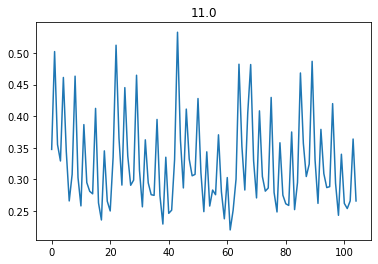

In [10]:
# Visualize some of the input

_ = plt.plot(x_train[200].flatten())
_ = plt.title(y_train[200])

In [ ]:
# TRY KERAS TUNER

# ResNet params
resnet_heads = 15

# Attention params
num_epochs = 3
batch_size = 64
nodes = 512 #512
learning_rate = 3e-3

head_size = 256 # 256,64
num_heads = 8
ff_dim= 16
num_transformer_blocks= 15
mlp_units=[nodes]*2,  # 128
mlp_dropout=0.3,     #0.4
dropout=0.2    


def model_builder(
    input_shape,
    hp,
    head_size = head_size,
    num_heads = num_heads,
    ff_dim = ff_dim,
    num_transformer_blocks = num_transformer_blocks,
    mlp_units = mlp_units,    
    dropout=0,
    mlp_dropout=0,    
):
    inputs = tf.keras.Input(shape=input_shape)
    # x = inputs
    x =   layers.Conv2D(filters=64, kernel_size=3, padding="same")(inputs)
    
    for _ in range(resnet_heads):
        x = ResNetBlock(x)
        
    x = tf.reduce_sum(x,axis=-1)
    
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    # Pool or average
    # x = layers.GlobalAveragePooling1D()(x)#data_format="channels_first"    
    # x = layers.Flatten()(x)
    
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="softmax")(x)
    x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy']) 
    return tf.keras.Model(inputs, outputs)

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(x_train, y_train, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [15]:
# Define Sequential model with 3 layers
input_shape = (x_train.shape[1:]) + (1,) #input_shape = (21,5,) #x_train.shape[2]


def ResNetBlock(x):
    x =   layers.Conv2D(filters=64, kernel_size=3, padding="same")(x) #input_layer
    conv1 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(x) # input_layer, Conv1D
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.ReLU()(conv1)

    conv2 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.ReLU()(conv2)

    conv3 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.ReLU()(conv3)
    
    conv4 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.ReLU()(conv4)
    
    conv5 = layers.Conv2D(filters=64, kernel_size=3, padding="same")(conv4)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.ReLU()(conv5)
    
    conv5 = layers.add([x,conv5])
    x = layers.ReLU()(conv3) # Overwrite x
    
    return x

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv2D(filters=ff_dim, kernel_size=1,padding="same", activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv2D(filters=ff_dim, kernel_size=1,padding="same", activation="relu")(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,    
    dropout=0,
    mlp_dropout=0,    
):
    inputs = tf.keras.Input(shape=input_shape)
    # x = inputs
    x =   layers.Conv2D(filters=64, kernel_size=3, padding="same")(inputs)
    
    for _ in range(resnet_heads):
        x = ResNetBlock(x)
        
    # x = tf.reduce_sum(x,axis=-1)
    
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    # Pool or average
    # x = layers.GlobalAveragePooling1D()(x)#data_format="channels_first"    
    # x = layers.Flatten()(x)
    
    for _ in range(mlp_units):
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="softmax")(x)
    x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)



# ResNet params
resnet_heads = 5

# Attention params
num_epochs = 30
batch_size = 64
nodes = 512 #512
learning_rate = 1e-3

head_size = 128 # 256,64
num_heads = 15
ff_dim= 64
num_transformer_blocks= 25
mlp_units= 5  # 128
mlp_dropout=0.3     #0.4
dropout=0.2          #0.25



wandb.config = {
  "learning_rate": "learning_rate",
  "epochs": num_epochs, 
  "batch_size": batch_size,
  "nodes": nodes,
  "row_length":row_length,
  "base_path":base_path,
  "head_size":head_size, "num_heads":num_heads,
  "ff_dim":ff_dim, "num_transformer_blocks":num_transformer_blocks,
  "mlp_units":mlp_units, "mlp_dropout":mlp_dropout,
  "dropout":dropout
}

model = build_model(input_shape,head_size=head_size,num_heads=num_heads,ff_dim=ff_dim,
                    num_transformer_blocks = num_transformer_blocks,mlp_units=mlp_units, mlp_dropout=mlp_dropout,dropout=dropout)
# model.summary()


# Poly Rate scheduler
starter_learning_rate = 0.001
end_learning_rate = 0.0001
decay_steps = 1000
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.25)

# Callbacks
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.25, patience=5, min_lr=0.0001),
    #EarlyStopping(monitor="val_loss", patience=25, verbose=1), 
    WandbCallback()
]

# Trying different optimizers
opt1 = tf.keras.optimizers.RMSprop(learning_rate=learning_rate,rho=0.9,momentum=0.9, epsilon=1e-07,centered=True,name="RMSprop")
opt2 = tf.keras.optimizers.Adam(learning_rate=learning_rate,amsgrad=True)
opt3 = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True, name="SGD")
poly_rate = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn)
poly_rate2 = tf.keras.optimizers.Adam(learning_rate = learning_rate_fn)
top_K = 3

start_time = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')

print(f'Training start time:{start_time}')

# model.compile( optimizer = opt, loss= 'categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(top_K, name="top-3-accuracy")])  #label_smoothing=0.05, tf.keras.losses.KLDivergence()
#model.compile( optimizer=opt1,loss="sparse_categorical_crossentropy" , metrics=["sparse_categorical_accuracy"],) #"sparse_categorical_crossentropy" , sparse_categorical_accuracy", tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)
model.compile( optimizer=opt2,loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2) , metrics=["accuracy"],) #"sparse_categorical_crossentropy" , sparse_categorical_accuracy", tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)


history = model.fit(x_train_new, y_train_1hot,
          epochs= num_epochs, 
          batch_size= batch_size, 
          validation_data=(x_test_new, y_test_1hot),
         callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]



Training start time:01_December_21_0834
Epoch 1/30
11467/11467 [==============================] - 4720s 410ms/step - loss: 2.7208 - accuracy: 0.1360 - val_loss: 2.7947 - val_accuracy: 0.1066
Epoch 2/30
11467/11467 [==============================] - 4722s 412ms/step - loss: 2.7083 - accuracy: 0.1355 - val_loss: 2.7916 - val_accuracy: 0.1066
Epoch 3/30
11467/11467 [==============================] - 4725s 412ms/step - loss: 2.7083 - accuracy: 0.1365 - val_loss: 2.7966 - val_accuracy: 0.0826
Epoch 4/30
11467/11467 [==============================] - 4731s 413ms/step - loss: 2.7083 - accuracy: 0.1361 - val_loss: 2.7950 - val_accuracy: 0.0826
Epoch 5/30
11467/11467 [==============================] - 4738s 413ms/step - loss: 2.7083 - accuracy: 0.1353 - val_loss: 2.7902 - val_accuracy: 0.1066
Epoch 6/30
11467/11467 [==============================] - 4745s 414ms/step - loss: 2.7083 - accuracy: 0.1360 - val_loss: 2.7949 - val_accuracy: 0.0826
Epoch 7/30
11467/11467 [==============================

KeyboardInterrupt: 

In [ ]:
_, accuracy = model.evaluate(x_val, y_val)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")


model.save(f'{base_path}//{ipynbname.name()}//{time_stamp}_Acc_{accuracy}_{row_length}x{col_length}.h5')

In [ ]:
# Train further
if accuracy < 0.7:
    history = model.fit(x_train, y_train,
          epochs= 20, 
          batch_size= batch_size, 
          validation_data=(x_test, y_test),
         callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]